In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("harvest_data_plus_environmental_data.csv")

In [3]:
data = data[data['SEX'] == 'M'] # subsetting data to just males

## EDA:

Text(0.5, 1.0, 'Average Age of Harvested Male Deer by Training Site')

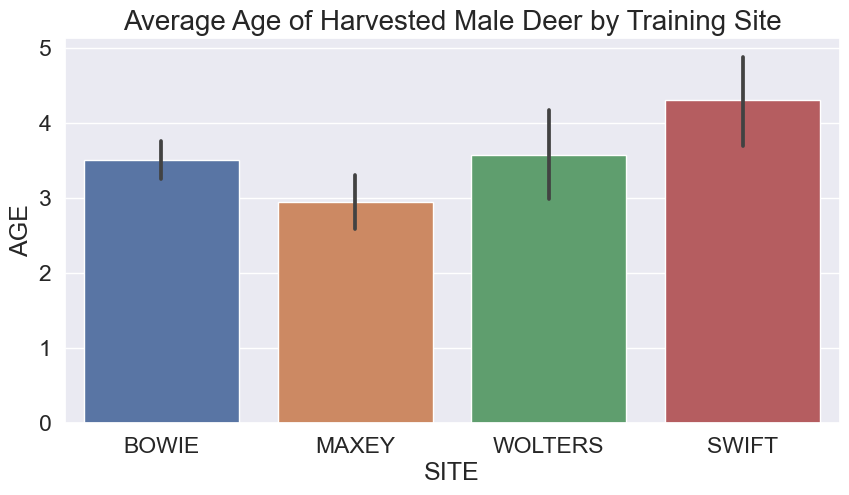

In [4]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average Age of Harvested Male Deer by Training Site', fontsize=20)

Text(0.5, 1.0, 'Number of Males Harvested by Year')

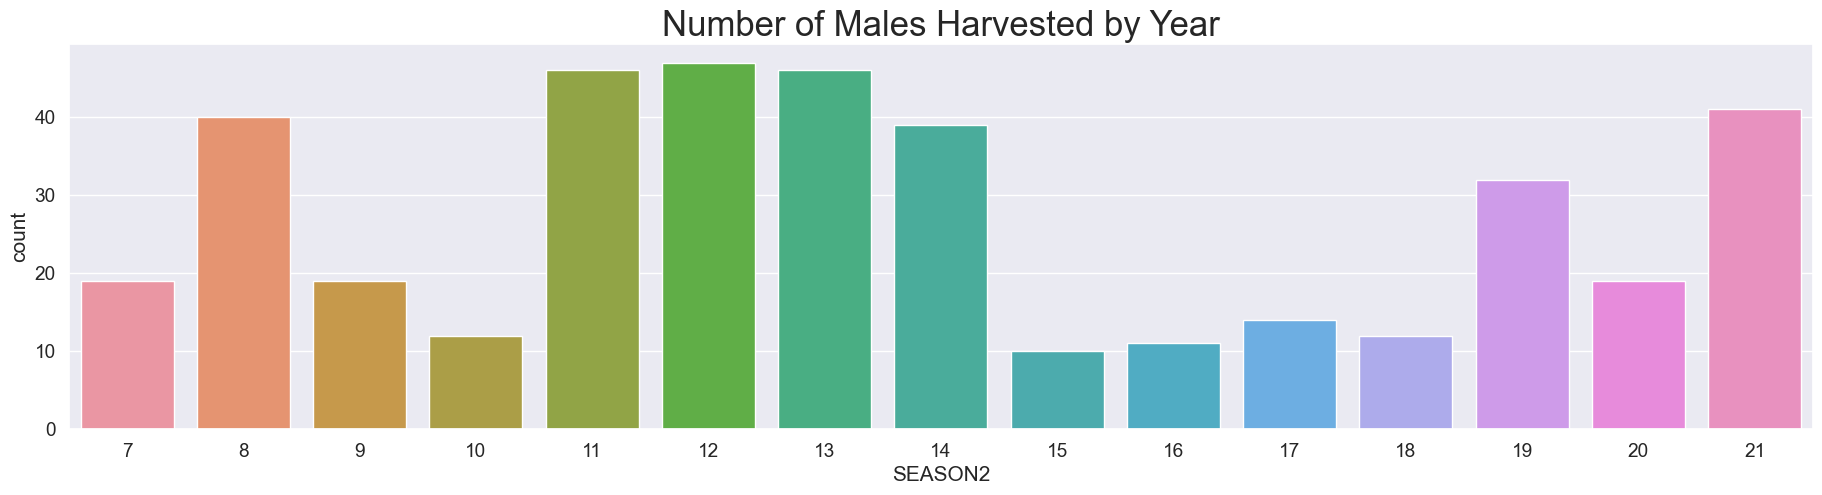

In [5]:
sns.set(rc={"figure.figsize":(22.5, 5)}, font_scale = 1.25) 
sns.countplot(x = 'SEASON2', data = data)
plt.title('Number of Males Harvested by Year', fontsize=25) 

# the x-axis values correspond to year (e.g., '7' = 2007, '10' = 2010, and so on.)

Text(0.5, 1.0, 'Male Body Mass (bm.kg) by Age')

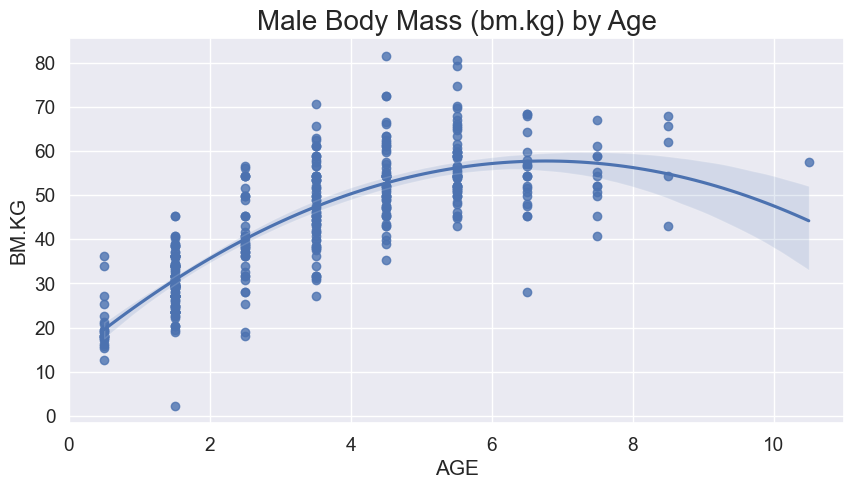

In [6]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'AGE', y = 'BM.KG', data = data, order=2)
plt.title('Male Body Mass (bm.kg) by Age', fontsize=20)

Notice the positive, curvilinear relationship between body mass and age.  However, as males reach about 6 years body mass pleateaus and begins to decline 

In [7]:
data.drop(['PREFIX-ID','DATE','ID','DATE+#','a,b,etc.','DATE TAKEN','SEASON','SEASONCAT','LIVE.BM.KG',
           'LIVE WEIGHT','BM.LB','POINTS.L','POINTS.R','SPREAD.IN','SPREAD.MM','BASAL.CIR.L.IN',
           'BASAL.CIR.L.MM','BASAL.CIR.R.IN','BASAL.CIR.R.MM ','BEAM.L.IN','BASAL.T.MM','BEAM.L.MM',
           'BEAM.R.IN','BEAM.R.MM','LACTATION','NOTES','BEAM.T.MM'],axis=1, inplace=True)

In [8]:
data['SITE'].replace(['BOWIE', 'SWIFT','MAXEY','WOLTERS'],[0, 1, 2, 3], inplace=True)
data['SEX'].replace(['M','F'],[0, 1], inplace=True)

In [9]:
data.dropna(subset=['BM.KG','AGE'],inplace=True)

In [10]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
SEASON2 : 0 NaN
SEX : 0 NaN
SITE : 0 NaN
AGE : 0 NaN
BM.KG : 0 NaN
rain_lag_0 : 0 NaN
rain_lag_1 : 0 NaN
rain_lag_2 : 0 NaN
rain_lag_3 : 0 NaN
rain_lag_4 : 0 NaN
rain_lag_5 : 0 NaN


Text(0.5, 1.0, 'Average age of harvested male deer by training site')

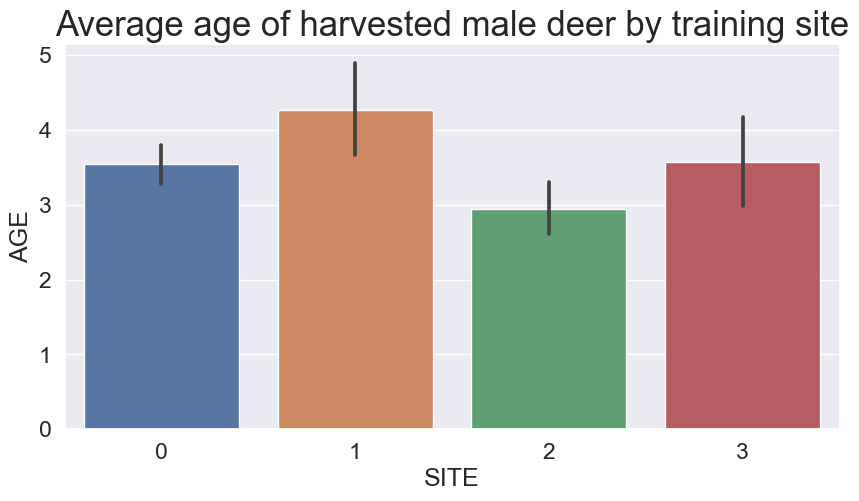

In [11]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average age of harvested male deer by training site', fontsize=25)

In [12]:
data.corr() # Looking at correlations between rain_lags.  Dropping all rain lags  that correlate highly with other rain lags

,SEASON2,SEX,SITE,AGE,BM.KG,rain_lag_0,rain_lag_1,rain_lag_2,rain_lag_3,rain_lag_4,rain_lag_5
SEASON2,1.000000,NaN,0.170882,0.327567,0.353774,0.019887,-0.022805,0.079959,0.104306,0.140299,0.110219
SEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SITE,0.170882,NaN,1.000000,-0.048332,-0.070869,0.491770,0.444066,0.463960,0.406981,0.403107,0.406493
AGE,0.327567,NaN,-0.048332,1.000000,0.758530,-0.117198,-0.148748,-0.052568,-0.043305,-0.027680,-0.090444
BM.KG,0.353774,NaN,-0.070869,0.758530,1.000000,-0.028294,-0.078619,0.016998,0.074421,0.114746,0.012337
rain_lag_0,0.019887,NaN,0.491770,-0.117198,-0.028294,1.000000,0.870571,0.904827,0.856590,0.744027,0.683060
rain_lag_1,-0.022805,NaN,0.444066,-0.148748,-0.078619,0.870571,1.000000,0.856557,0.791182,0.776190,0.730248
rain_lag_2,0.079959,NaN,0.463960,-0.052568,0.016998,0.904827,0.856557,1.000000,0.835692,0.742204,0.710979
rain_lag_3,0.104306,NaN,0.406981,-0.043305,0.074421,0.856590,0.791182,0.835692,1.000000,0.802852,0.532393
rain_lag_4,0.140299,NaN,0.403107,-0.027680,0.114746,0.744027,0.776190,0.742204,0.802852,1.000000,0.522350


Kept rain lag 3 and 4 because they are the only rain lags that don't correlate highly with other rain lags

In [13]:
X = data[['AGE','SITE','SEASON2', 'rain_lag_4', 'rain_lag_3']] 
y = data['BM.KG']

Fit a linear regression model initially 

In [14]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary()) ## not a bad r-squared.  

                            OLS Regression Results                            
Dep. Variable:                  BM.KG   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     122.9
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.69e-77
Time:                        14:22:03   Log-Likelihood:                -1405.5
No. Observations:                 391   AIC:                             2823.
Df Residuals:                     385   BIC:                             2847.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1065      1.789      9.004      0.0

In [15]:
pred = est2.predict(X2)
print(pred)

143     25.669650
144     25.669650
147     25.669650
148     25.669650
149     25.669650
          ...    
1569    31.414974
1572    57.395608
1573    26.218848
1577    62.591734
1580    36.611101
Length: 391, dtype: float64


In [16]:
mae = mean_absolute_error(data['BM.KG'], pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 6.696239600842522


Contrast results of linear model with a few machine learning models to see if predictors' feature importances vary among fitted and tuned models

In [17]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

KFold cross validation to assess overfit

In [18]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [4.80836015 5.36498967 6.27726859 6.76044267 6.857729   6.16168386
 6.41598786 7.75537413 7.45287118 7.70119161]
MAE average:  6.555589872055718


In [19]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [5.21057291 5.4323474  5.21869798 6.3106215  6.84070182 6.75998957
 7.95648925 7.26592682 7.04752854 7.00059476]
MAE average:  6.504347057313701


In [20]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [5.21181234 5.41032625 6.05576451 6.7173187  6.64176293 7.0675831
 6.63597438 7.39887311 7.20580714 8.32811697]
MAE average:  6.667333942954869


Tune hyperparamters via grid search 

In [21]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [22]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [23]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [24]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [25]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [26]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [27]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
[14:24:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

Assess if predictors have similar feature importance scores among models

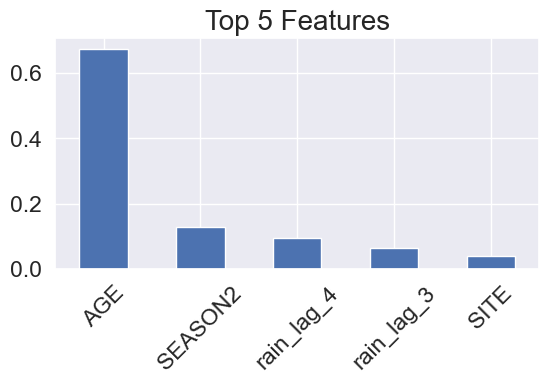

In [28]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

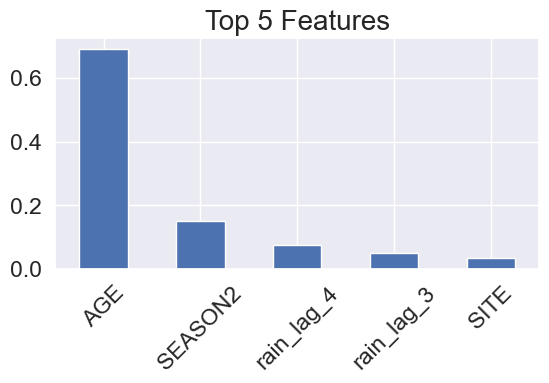

In [29]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.show()

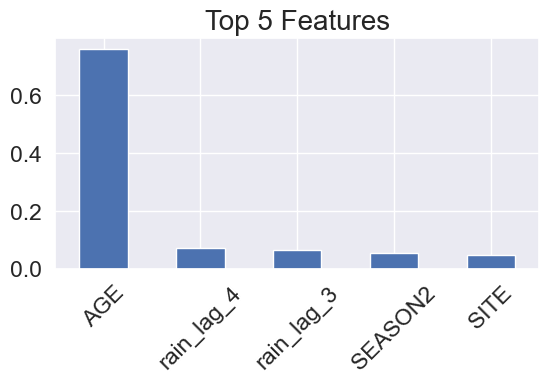

In [30]:
feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

Mostly agreement among the three models and linear model.  The linear model weighted 'SITE' (i.e., the training site where the deer was harvested) higher than the ML models 